In [1]:
%%capture

import importlib

from tools.system_tools import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
import cnn
from skimage import measure
from tools.load_nc import load_nc_phys, load_nc_sinmod, load_nc_obs
from matplotlib.patches import Rectangle
import pandas as pd
from scipy.interpolate import griddata, interp2d
from scipy.signal import resample
from tools import grid_conversion
from scipy.spatial import cKDTree
import tools.system_tools

# Prepare data for analysis

### Load NC data

In [2]:
# Get CMEMS-phys data
fPath = 'D:/master/data/compare/CMEMS_phys/phys_465.nc' # 01.06.2017
lons_phys,lats_phys,sst_phys,ssl_phys,sal_phys,uvel_phys,vvel_phys =  load_nc_phys(fPath)
# Get SINMOD data
fPath = 'D:/master/data/compare/sinmod/samples_2017.06.01_nonoverlap.nc' # 01.06.2017
x_sinmod,y_sinmod,z_sinmod,lons_sinmod,lats_sinmod,sst_sinmod,ssl_sinmod,sal_sinmod,uvel_sinmod,vvel_sinmod =  load_nc_sinmod(fPath)
# Get CMEMS-multiobs data


In [3]:
fPath = 'D:/master/data/compare/CMEMS_multiobs/phys_152.nc' # 31.05.2017
lons_obs,lats_obs,sst_obs,ssl_obs,sal_obs,uvel_obs,vvel_obs,_ =  load_nc_obs(fPath)

### Convert CMEMSphys data to north-polar sterographic projection

In [4]:
# Get a polar steregraphic projection with cartesian irregular curvilinear grid for CMEMS-phys data 
x_phys_2d, y_phys_2d = grid_conversion.bl2xy(*np.meshgrid(lons_phys, lats_phys), FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)

In [5]:
# Get a polar steregraphic projection with cartesian irregular curvilinear grid for CMEMS-multiobs data 
x_obs_2d, y_obs_2d = grid_conversion.bl2xy(*np.meshgrid(lons_obs, lats_obs), FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)

### Interpolate CMEMSphys data to high enough resolution such that extracting closest neighbor from the CMEMSphys measurements based on queries from the selected SINMOD grid won't have duplicates.

In [6]:
# Interpolate data and the curvilienar grid axes such that it has a higher resolution than SINMOD
sst_phys_it = interp2d_masked(sst_phys, lons_phys, lats_phys, 4, 'linear')
ssl_phys_it = interp2d_masked(ssl_phys, lons_phys, lats_phys, 4, 'linear')
sal_phys_it = interp2d_masked(sal_phys, lons_phys, lats_phys, 4, 'linear')
uvel_phys_it = interp2d_masked(uvel_phys, lons_phys, lats_phys, 4, 'linear')
vvel_phys_it = interp2d_masked(vvel_phys, lons_phys, lats_phys, 4, 'linear')
x_phys_it = interp2d_masked(x_phys_2d.T, lons_phys, lats_phys, 4, 'linear')
y_phys_it = interp2d_masked(y_phys_2d.T, lons_phys, lats_phys, 4, 'linear')

In [7]:
# Interpolate data and the curvilienar grid axes such that it has a higher resolution than SINMOD
sst_obs_it = interp2d_masked(sst_obs, lons_obs, lats_obs, 8, 'linear')
ssl_obs_it = interp2d_masked(ssl_obs, lons_obs, lats_obs, 8, 'linear')
sal_obs_it = interp2d_masked(sal_obs, lons_obs, lats_obs, 8, 'linear')
uvel_obs_it = interp2d_masked(uvel_obs, lons_obs, lats_obs, 8, 'linear')
vvel_obs_it = interp2d_masked(vvel_obs, lons_obs, lats_obs, 8, 'linear')
x_obs_it = interp2d_masked(x_obs_2d.T, lons_obs, lats_obs, 8, 'linear')
y_obs_it = interp2d_masked(y_obs_2d.T, lons_obs, lats_obs, 8, 'linear')

### Test what grid we want to check

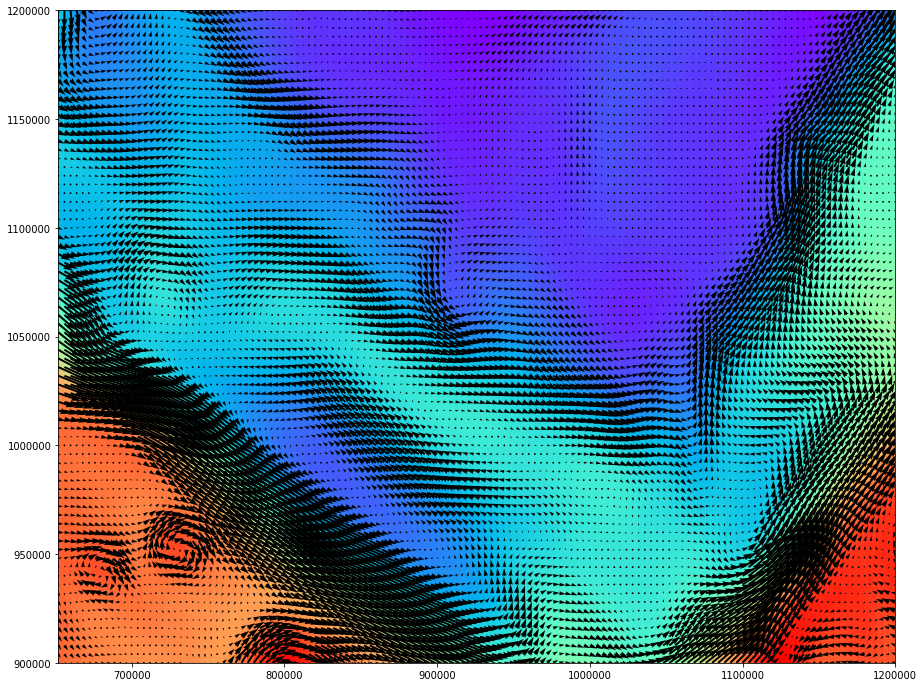

In [8]:

#fPath = 'D:/master/data/compare/sinmod/samples_2016.09.10_nonoverlap.nc'
#x_sinmod,y_sinmod,lons_sinmod,lats_sinmod,sst_sinmod,ssl_sinmod,sal_sinmod,uvel_sinmod,vvel_sinmod =  load_nc_sinmod(fPath)

# Norske kysten
x_bnds = [650000, 1200000]
y_bnds = [900000, 1200000]

# Mellom Svalbard og Grønland, potensielt mye rart som slipper mellom der
#x_bnds = [1500000, 2100000]
#y_bnds = [1600000, 1850000]
#
#x_bnds = [800000, 2400000]
#y_bnds = [1000000, 1900000]

# Norge Danmark
#x_bnds = [550000, 900000]
#y_bnds = [150000, 400000]

x_idxs = np.where((x_sinmod >= x_bnds[0]) & (x_sinmod <= x_bnds[1]))[0]
y_idxs = np.where((y_sinmod >= y_bnds[0]) & (y_sinmod <= y_bnds[1]))[0]

x = np.ma.array(x_sinmod[x_idxs])
y = np.ma.array(y_sinmod[y_idxs])
lons = np.ma.array(lons_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
lats = np.ma.array(lats_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
sst = np.ma.array(sst_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
ssl = np.ma.array(ssl_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
sal = np.ma.array(sal_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
uvel = np.ma.array(uvel_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
vvel = np.ma.array(vvel_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])

uvel, vvel = rotate_vector(uvel, vvel, lons, 58)

fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.pcolormesh(x, y, ssl.T, cmap='rainbow')
#ax.streamplot(x, y, uvel.T, vvel.T, density=9) 
ax.quiver(x,y,uvel.T,vvel.T,scale=10)


### Select a grid that will be our basis of analysis

In [9]:
# Get SINMOD Grid
#x_bnds = [100000, 500000]
#y_bnds = [1650000, 1900000]
# Mellom Grønland, Svalbard og Norge
#x_bnds = [1800000, 2150000]
#y_bnds = [1600000, 1870000]

#
#x_bnds = [2370000, 2500000]
#y_bnds = [800000, 1000000]

#x_bnds = [700000, 1200000]
#y_bnds = [900000, 1200000]

# norge danmark
#x_bnds = [550000, 900000]
#y_bnds = [150000, 400000]

# Norskekysten
x_bnds = [700000, 1200000]
y_bnds = [900000, 1250000]

# Barents Sea
#x_bnds = [2350000, 2600000]
#y_bnds = [800000, 1050000]

x_idxs = np.where((x_sinmod >= x_bnds[0]) & (x_sinmod <= x_bnds[1]))[0]
y_idxs = np.where((y_sinmod >= y_bnds[0]) & (y_sinmod <= y_bnds[1]))[0]

x_sinmod = np.ma.array(x_sinmod[x_idxs])
y_sinmod = np.ma.array(y_sinmod[y_idxs])
lons_sinmod = np.ma.array(lons_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
lats_sinmod = np.ma.array(lats_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
sst_sinmod = np.ma.array(sst_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
ssl_sinmod = np.ma.array(ssl_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
sal_sinmod = np.ma.array(sal_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
uvel_sinmod = np.ma.array(uvel_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])
vvel_sinmod = np.ma.array(vvel_sinmod[x_idxs[0]:x_idxs[-1]+1, y_idxs[0]:y_idxs[-1]+1])


### Create k-d tree to create a CMEMSphys grid with same axes as the selected SINMOD grid

In [10]:
# Create cKDTree object to represent the full flattened cartesian coordinates of the CMEMSphys data grid
tree_phys = cKDTree(list(zip(x_phys_it.flatten(), y_phys_it.flatten())))

In [11]:
# Create cKDTree object to represent the full flattened cartesian coordinates of the CMEMSphys data grid
tree_obs = cKDTree(list(zip(x_obs_it.flatten(), y_obs_it.flatten())))

In [12]:
# Find indices of the CMEMSphys data nearest to the SINMOD coordinates we use
x_query, y_query = np.meshgrid(x_sinmod, y_sinmod)
d, inds = tree_phys.query(list(zip(x_query.ravel(), y_query.ravel())), k = 1)

# Extract phys data by query indexes to get same grid axes and apply the same landmass mask
sinmod_mask = np.ma.getmask(ssl_sinmod)
sst_phys_samegrid = np.ma.masked_where(sinmod_mask, sst_phys_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
ssl_phys_samegrid = np.ma.masked_where(sinmod_mask, ssl_phys_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
sal_phys_samegrid = np.ma.masked_where(sinmod_mask, sal_phys_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
uvel_phys_samegrid = np.ma.masked_where(sinmod_mask, uvel_phys_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
vvel_phys_samegrid = np.ma.masked_where(sinmod_mask, vvel_phys_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)

d, inds = tree_obs.query(list(zip(x_query.ravel(), y_query.ravel())), k = 1)

# Extract phys data by query indexes to get same grid axes and apply the same landmass mask
sinmod_mask = np.ma.getmask(ssl_sinmod)
sst_obs_samegrid = np.ma.masked_where(sinmod_mask, sst_obs_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
ssl_obs_samegrid = np.ma.masked_where(sinmod_mask, ssl_obs_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
sal_obs_samegrid = np.ma.masked_where(sinmod_mask, sal_obs_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
uvel_obs_samegrid = np.ma.masked_where(sinmod_mask, uvel_obs_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)
vvel_obs_samegrid = np.ma.masked_where(sinmod_mask, vvel_obs_it.flatten()[inds].reshape(uvel_sinmod.T.shape).T)

In [13]:
# Rotate velocities to fit the shifted pole stereographic projection
uvel_sinmod, vvel_sinmod = rotate_vector(uvel_sinmod, vvel_sinmod, lons_sinmod, 58)
uvel_phys_samegrid, vvel_phys_samegrid = rotate_vector(uvel_phys_samegrid, vvel_phys_samegrid, lons_sinmod, 58)
uvel_obs_samegrid, vvel_obs_samegrid = rotate_vector(uvel_obs_samegrid, vvel_obs_samegrid, lons_sinmod, 58)

Text(0.5, 1.0, 'test')

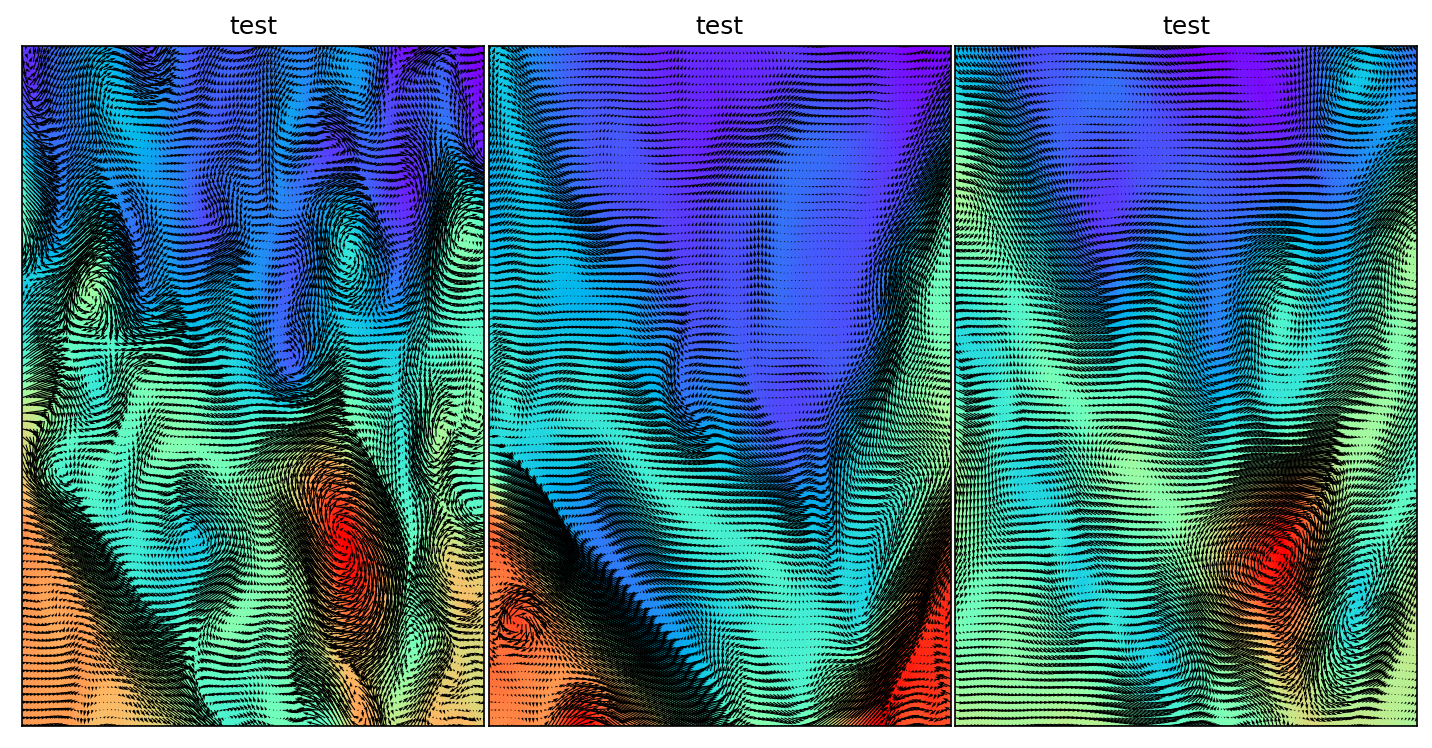

In [14]:
fig, ax = plt.subplots(1,3,figsize=(12,6), dpi=150)
fig.subplots_adjust(wspace=0.01, hspace=0)

#import matplotlib.gridspec as gridspec
#gs = gridspec.GridSpec(1, 2)
#gs.update(wspace=0.02, hspace=0.05) # set the spacing between axes. 

ax[0].pcolormesh(x_sinmod, y_sinmod, ssl_phys_samegrid.T, cmap='rainbow')
ax[0].quiver(x_sinmod,y_sinmod,uvel_phys_samegrid.T,vvel_phys_samegrid.T,scale=4)
#ax[0].streamplot(x_sinmod,y_sinmod,uvel_phys_samegrid.T,vvel_phys_samegrid.T,density=6)
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].set_title('test')

ax[1].pcolormesh(x_sinmod, y_sinmod, ssl_sinmod.T, cmap='rainbow')
ax[1].quiver(x_sinmod,y_sinmod,uvel_sinmod.T,vvel_sinmod.T,scale=4) 
#ax[1].streamplot(x_sinmod,y_sinmod,uvel_sinmod.T,vvel_sinmod.T,density=6) 
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_title('test')

ax[2].pcolormesh(x_sinmod, y_sinmod, ssl_obs_samegrid.T, cmap='rainbow')
ax[2].quiver(x_sinmod,y_sinmod,uvel_obs_samegrid.T,vvel_obs_samegrid.T,scale=4)
#ax[0].streamplot(x_sinmod,y_sinmod,uvel_phys_samegrid.T,vvel_phys_samegrid.T,density=6)
ax[2].axes.get_xaxis().set_visible(False)
ax[2].axes.get_yaxis().set_visible(False)
ax[2].set_title('test')

# Process CMEMS-phys data

### Perform pyramid sliding window on grid and return use CNN model to predict rectangles

In [17]:
%%capture
importlib.reload(cnn)
model_fpath = 'C:/Users/47415/Master/TTK-4900-Master/models/cnn_model_975.h5'
cnn_win_sizes = [((int(6), int(5)), 2, 2),((int(8), int(6)), 3, 2)]#,((int(11), int(8)), 3, 2)]
#cnn_win_sizes = [((int(8), int(6)), 2, 2)]
cnn_data = [lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, ssl_phys_samegrid, uvel_phys_samegrid, vvel_phys_samegrid]
# Get the cyclone and anti-cyclone rectangle 
cyclones_phys, anticyclones_phys, _, _ = cnn.cnn_predict_grid(cnn_data, cnn_win_sizes, 0.96, model_fpath, storedir="phys1")

In [18]:
# Group all predicted boxes according to overlap and number of rectangles in a group
cyc_phys, _ = cv2.groupRectangles(rectList=cyclones_phys, groupThreshold=1, eps=0.15)
acyc_phys, _ = cv2.groupRectangles(rectList=anticyclones_phys, groupThreshold=1, eps=0.15)
nCyc, nAcyc = len(cyc_phys), len(acyc_phys)

### Use labeled binary clusters for each cyclone or anti-cyclone based on Okubo Weiss parameter and vorticity to find appropriate box surrounding the eddy

In [19]:
%%capture
# Create mask for OW values above threshold, one that contains cyclones (negative vorticity) 
# and vice versa for anti-cyclones
# Default Okubo Weiss value was -1, want to use -8 to be absolutely sure, we have a more loose threshold to
# indicate cells with vortex characteristics
OW_start = -0.05
OW,vorticity,OW_mask,OW_cyc_mask,OW_acyc_mask = calc_OW(lons_sinmod,lats_sinmod,uvel_phys_samegrid,vvel_phys_samegrid,OW_start)

# We label all unique mask clusters
OW_mask_labeled = measure.label(OW_mask)
cyc_mask_labeled_phys = measure.label(OW_cyc_mask)
acyc_mask_labeled_phys = measure.label(OW_acyc_mask)

# Make the predicted boxes encompass the full cyclone or anti-cyclone clusters and return info about the eddy
cyc_ctrIdxs, cyc_minOW, cyc_new_phys = tools.system_tools.investigate_cluster(cyc_phys, OW, cyc_mask_labeled_phys, 'cyclone')
acyc_ctrIdxs, acyc_minOW, acyc_new_phys = tools.system_tools.investigate_cluster(acyc_phys, OW, acyc_mask_labeled_phys, 'anti-cyclone')

# Eddy boxes given in lat-lon coordiantes
cyc_boxcoords_phys = box2coords(x_sinmod, y_sinmod, cyc_new_phys)
acyc_boxcoords_phys = box2coords(x_sinmod, y_sinmod, acyc_new_phys)

(900000, 1250000)

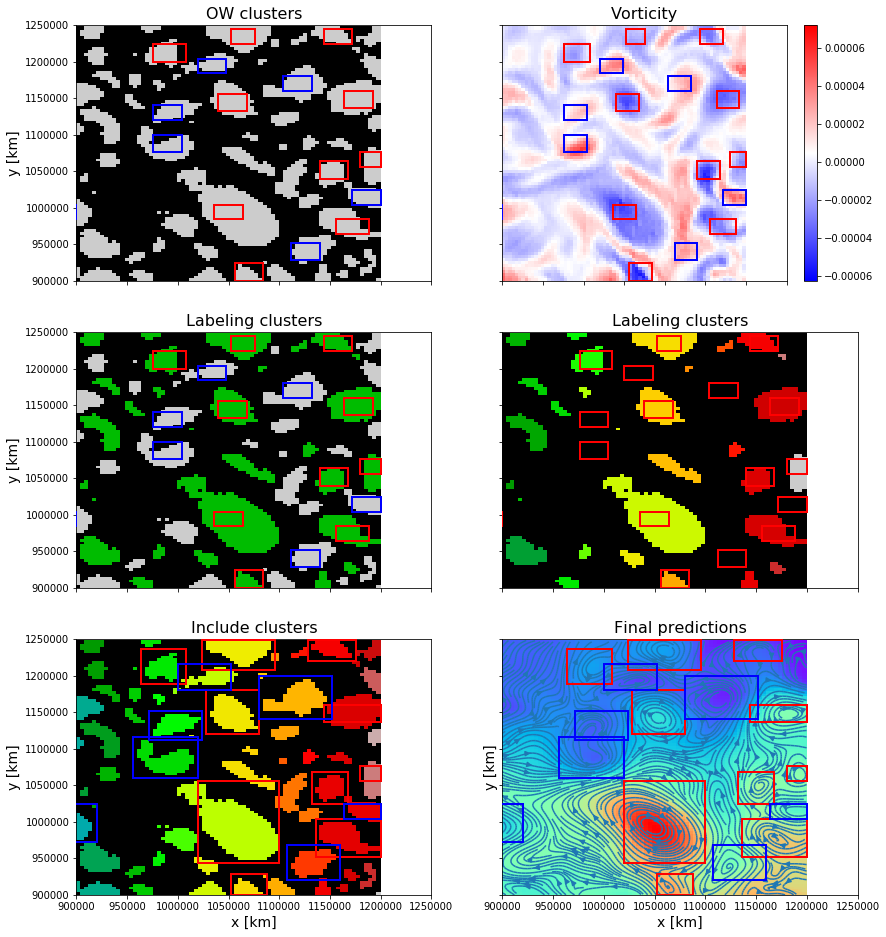

In [20]:

importlib.reload(tools.system_tools)
fig, ax = plt.subplots(3,2,figsize=(14,16), sharey=True, sharex=True)#, dpi=100)

cyc_box = box2coords(x_sinmod, y_sinmod, cyc_phys)
acyc_box = box2coords(x_sinmod, y_sinmod, acyc_phys)

ax[0,0].pcolormesh(x_sinmod, y_sinmod, OW_mask.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[0,0], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0,0], acyc_box, 'b', numbered=False)
ax[0,0].set_title('OW clusters', size=16)
ax[0,0].set_ylabel('y [km]', size=14)


test = np.zeros(OW_cyc_mask.shape)
test = np.where(OW_cyc_mask==1, 1, test)
test = np.where(OW_acyc_mask==1, 2, test)

ble = ax[0,1].pcolormesh(x_sinmod, y_sinmod, vorticity.T, cmap='bwr')
tools.system_tools.plot_eddies(ax[0,1], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0,1], acyc_box, 'b', numbered=False) 
ax[0,1].set_title('Vorticity', size=16)

plt.colorbar(ble, ax=ax[0,1])

ax[1,0].pcolormesh(x_sinmod, y_sinmod, test.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[1,0], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[1,0], acyc_box, 'b', numbered=False) 
ax[1,0].set_title('Labeling clusters', size=16)
ax[1,0].set_ylabel('y [km]', size=14)


ax[1,1].pcolormesh(x_sinmod, y_sinmod, cyc_mask_labeled_phys.T, cmap='nipy_spectral')
#ax[1,1].pcolormesh(x_sinmod, y_sinmod, acyc_mask_labeled_phys.T, cmap='nipy_spectral', alpha=0.5)
tools.system_tools.plot_eddies(ax[1,1], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[1,1], acyc_box, 'r', numbered=False) 
#tools.system_tools.plot_eddies(ax[1,1], acyc_boxcoords_phys, 'b', numbered=False) 
ax[1,1].set_title('Labeling clusters', size=16)

ax[2,0].pcolormesh(x_sinmod, y_sinmod, OW_mask_labeled.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[2,0], cyc_boxcoords_phys, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[2,0], acyc_boxcoords_phys, 'b', numbered=False) 
ax[2,0].set_title('Include clusters', size=16)
ax[2,0].set_ylabel('y [km]', size=14)
ax[2,0].set_xlabel('x [km]', size=14)

ax[2,1].pcolormesh(x_sinmod, y_sinmod, ssl_phys_samegrid.T, cmap='rainbow')
ax[2,1].streamplot(x_sinmod, y_sinmod, uvel_phys_samegrid.T, vvel_phys_samegrid.T, density=4) 
tools.system_tools.plot_eddies(ax[2,1], cyc_boxcoords_phys, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[2,1], acyc_boxcoords_phys, 'b', numbered=False) 
ax[2,1].set_title('Final predictions', size=16)
ax[2,1].set_ylabel('y [km]', size=14)
ax[2,1].set_xlabel('x [km]', size=14)

plt.ylim(y_bnds)
plt.xlim(y_bnds)

(700000, 1200000)

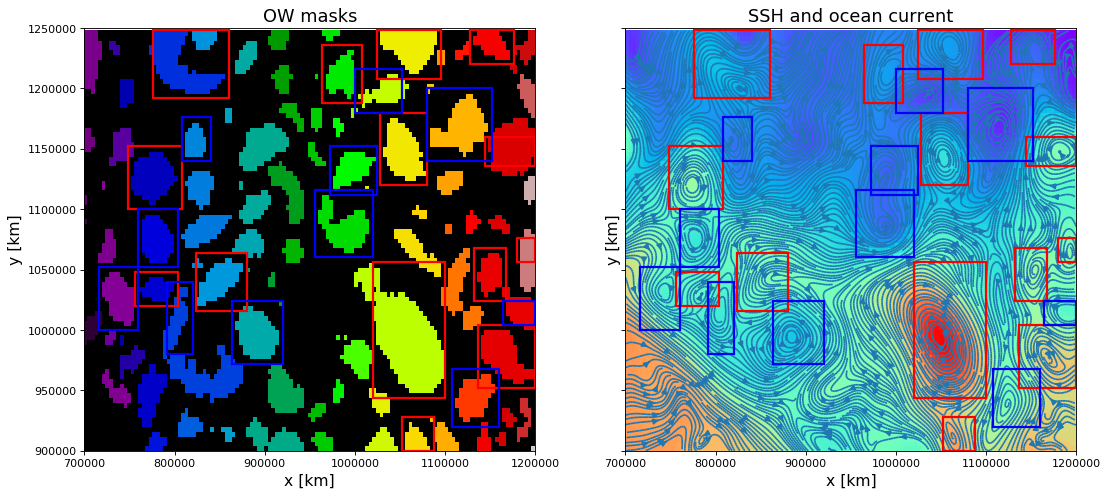

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,7), sharey=True, sharex=True, dpi=80)

ax[0].pcolormesh(x_sinmod, y_sinmod, OW_mask_labeled.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[0], cyc_boxcoords_phys, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0], acyc_boxcoords_phys, 'b', numbered=False) 
ax[0].set_title('OW masks', size=16)
ax[0].set_ylabel('y [km]', size=14)
ax[0].set_xlabel('x [km]', size=14)

ax[1].pcolormesh(x_sinmod, y_sinmod, ssl_phys_samegrid.T, cmap='rainbow')
ax[1].streamplot(x_sinmod, y_sinmod, uvel_phys_samegrid.T, vvel_phys_samegrid.T, density=6) 
tools.system_tools.plot_eddies(ax[1], cyc_boxcoords_phys, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[1], acyc_boxcoords_phys, 'b', numbered=False) 
ax[1].set_title('SSH and ocean current', size=16)
ax[1].set_ylabel('y [km]', size=14)
ax[1].set_xlabel('x [km]', size=14)

plt.ylim(y_bnds)
plt.xlim(x_bnds)

### Show box surrounding the marked OW clusters before and after

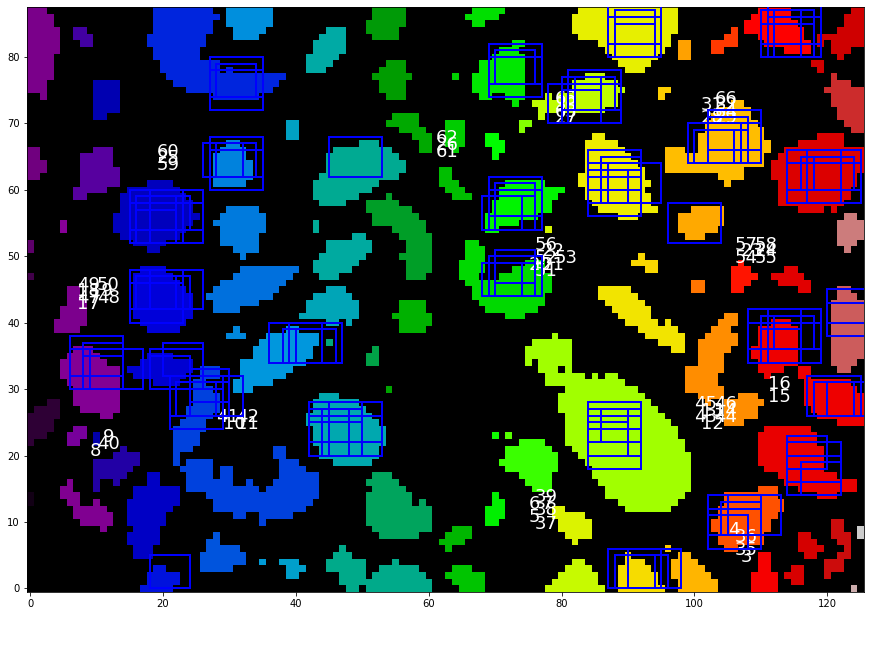

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(OW_mask_labeled.T, cmap='nipy_spectral', origin='lower')
# Before
#tools.system_tools.plot_eddies(ax, [cyc_phys[0]], 'r', numbered=False) 
#tools.system_tools.plot_eddies(ax, cyc_new_phys, 'b') 
tools.system_tools.plot_eddies(ax, cyclones_phys, 'b') 
# After
#tools.system_tools.plot_eddies(ax, [cyc_new_phys[0]], 'r', numbered=False) 
#tools.system_tools.plot_eddies(ax, acyc_new_phys, 'b', numbered=False) 
tools.system_tools.plot_eddies(ax, anticyclones_phys, 'b', numbered=False) 

#ax.set_xlim([7, 25])
#ax.set_ylim([4, 25])

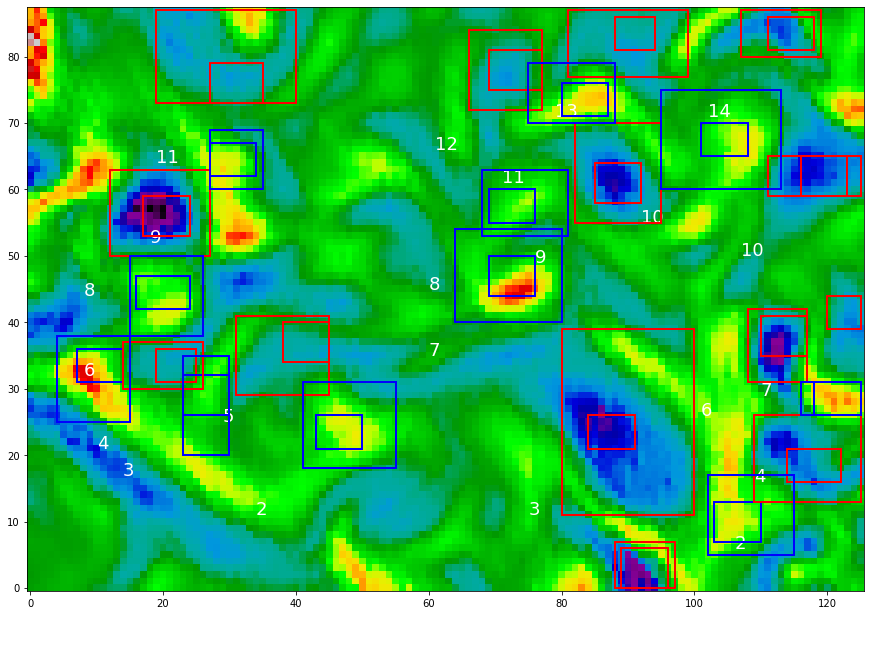

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(vorticity.T, cmap='nipy_spectral', origin='lower')
# Before
plot_eddies(ax, cyc_phys, 'r') 
plot_eddies(ax, acyc_phys, 'b') 
# After
plot_eddies(ax, cyc_new_phys, 'r', numbered=False) 
plot_eddies(ax, acyc_new_phys, 'b', numbered=False) 

### Show plot of velocity streamplot and sea surface level with new boxes

In [24]:
# Eddy census dataframe to hold information about each eddy
cyc_census_df_phys = set_eddy_census(cyc_mask_labeled_phys, cyc_ctrIdxs, cyc_new_phys, cyc_minOW, lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, uvel_phys_samegrid, vvel_phys_samegrid, meastype='SINMOD')
acyc_census_df_phys = set_eddy_census(acyc_mask_labeled_phys, acyc_ctrIdxs, acyc_new_phys, acyc_minOW, lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, uvel_phys_samegrid, vvel_phys_samegrid, meastype='SINMOD')

# Process CMEMS-multiobs data

### Perform pyramid sliding window on grid and return use CNN model to predict rectangles

In [27]:
%%capture
importlib.reload(cnn)
model_fpath = 'C:/Users/47415/Master/TTK-4900-Master/models/cnn_model_975.h5'
cnn_win_sizes = [((int(6), int(5)), 2, 2),((int(8), int(6)), 3, 2)]#,((int(11), int(8)), 3, 2)]
#cnn_win_sizes = [((int(8), int(6)), 2, 2)]
cnn_data = [lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, ssl_obs_samegrid, uvel_obs_samegrid, vvel_obs_samegrid]
# Get the cyclone and anti-cyclone rectangle 
cyclones_obs, anticyclones_obs, _, _= cnn.cnn_predict_grid(cnn_data, cnn_win_sizes, 0.96, model_fpath, storedir="phys1")

In [28]:
# Group all predicted boxes according to overlap and number of rectangles in a group
cyc_obs, _ = cv2.groupRectangles(rectList=cyclones_obs, groupThreshold=1, eps=0.15)
acyc_obs, _ = cv2.groupRectangles(rectList=anticyclones_obs, groupThreshold=1, eps=0.15)
nCyc, nAcyc = len(cyc_obs), len(acyc_obs)

### Use labeled binary clusters for each cyclone or anti-cyclone based on Okubo Weiss parameter and vorticity to find appropriate box surrounding the eddy

In [29]:
%%capture
# Create mask for OW values above threshold, one that contains cyclones (negative vorticity) 
# and vice versa for anti-cyclones
# Default Okubo Weiss value was -1, want to use -8 to be absolutely sure, we have a more loose threshold to
# indicate cells with vortex characteristics
OW_start = -0.1
OW,vorticity,OW_mask,OW_cyc_mask,OW_acyc_mask = calc_OW(lons_sinmod,lats_sinmod,uvel_obs_samegrid,vvel_obs_samegrid,OW_start)

# We label all unique mask clusters
OW_mask_labeled = measure.label(OW_mask)
cyc_mask_labeled_obs = measure.label(OW_cyc_mask)
acyc_mask_labeled_obs = measure.label(OW_acyc_mask)

# Make the predicted boxes encompass the full cyclone or anti-cyclone clusters and return info about the eddy
cyc_ctrIdxs, cyc_minOW, cyc_new_obs = tools.system_tools.investigate_cluster(cyc_obs, OW, cyc_mask_labeled_obs, 'cyclone')
acyc_ctrIdxs, acyc_minOW, acyc_new_obs = tools.system_tools.investigate_cluster(acyc_obs, OW, acyc_mask_labeled_obs, 'anti-cyclone')

# Eddy boxes given in lat-lon coordiantes
cyc_boxcoords_obs = box2coords(x_sinmod, y_sinmod, cyc_new_obs)
acyc_boxcoords_obs = box2coords(x_sinmod, y_sinmod, acyc_new_obs)

Text(0.5, 0, 'x [km]')

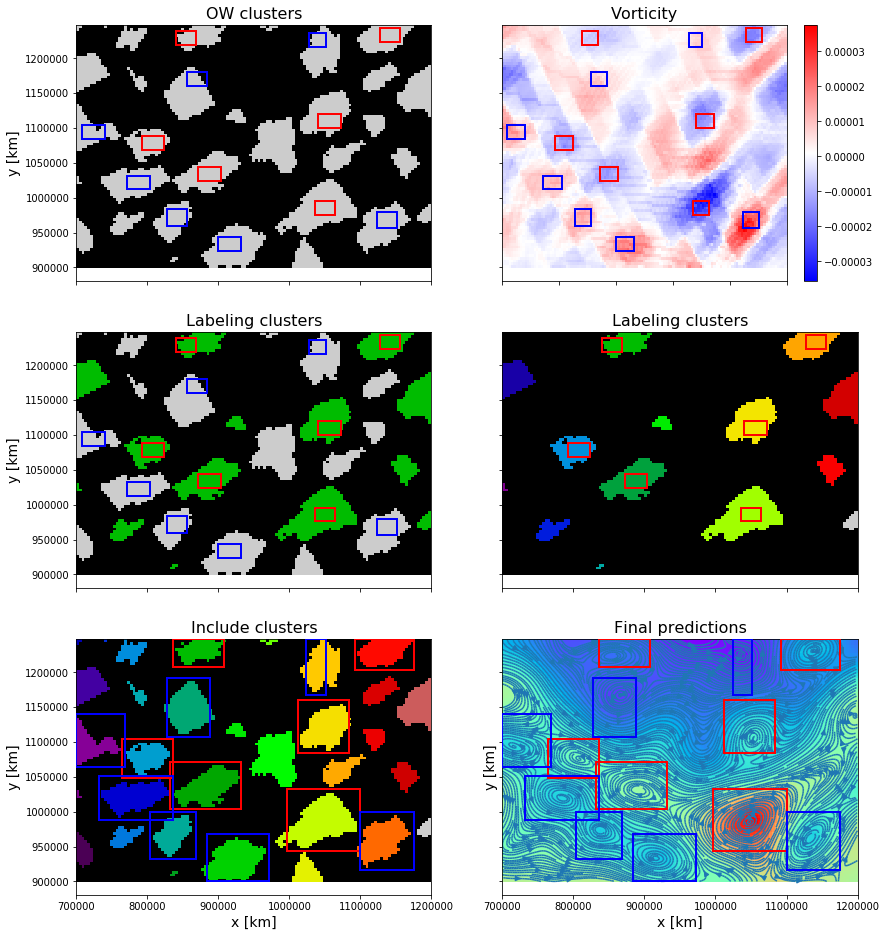

In [30]:

importlib.reload(tools.system_tools)
fig, ax = plt.subplots(3,2,figsize=(14,16), sharey=True, sharex=True)#, dpi=100)

cyc_box = box2coords(x_sinmod, y_sinmod, cyc_obs)
acyc_box = box2coords(x_sinmod, y_sinmod, acyc_obs)

ax[0,0].pcolormesh(x_sinmod, y_sinmod, OW_mask.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[0,0], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0,0], acyc_box, 'b', numbered=False)
ax[0,0].set_title('OW clusters', size=16)
ax[0,0].set_ylabel('y [km]', size=14)


test = np.zeros(OW_cyc_mask.shape)
test = np.where(OW_cyc_mask==1, 1, test)
test = np.where(OW_acyc_mask==1, 2, test)

ble = ax[0,1].pcolormesh(x_sinmod, y_sinmod, vorticity.T, cmap='bwr')
tools.system_tools.plot_eddies(ax[0,1], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0,1], acyc_box, 'b', numbered=False) 
ax[0,1].set_title('Vorticity', size=16)

plt.colorbar(ble, ax=ax[0,1])

ax[1,0].pcolormesh(x_sinmod, y_sinmod, test.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[1,0], cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[1,0], acyc_box, 'b', numbered=False) 
ax[1,0].set_title('Labeling clusters', size=16)
ax[1,0].set_ylabel('y [km]', size=14)


ax[1,1].pcolormesh(x_sinmod, y_sinmod, cyc_mask_labeled_obs.T, cmap='nipy_spectral')
#ax[1,1].pcolormesh(x_sinmod, y_sinmod, acyc_mask_labeled_obs.T, cmap='nipy_spectral', alpha=0.5)
tools.system_tools.plot_eddies(ax[1,1], cyc_box, 'r', numbered=False) 
#tools.system_tools.plot_eddies(ax[1,1], acyc_boxcoords_obs, 'b', numbered=False) 
ax[1,1].set_title('Labeling clusters', size=16)

ax[2,0].pcolormesh(x_sinmod, y_sinmod, OW_mask_labeled.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[2,0], cyc_boxcoords_obs, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[2,0], acyc_boxcoords_obs, 'b', numbered=False) 
ax[2,0].set_title('Include clusters', size=16)
ax[2,0].set_ylabel('y [km]', size=14)
ax[2,0].set_xlabel('x [km]', size=14)

ax[2,1].pcolormesh(x_sinmod, y_sinmod, ssl_obs_samegrid.T, cmap='rainbow')
ax[2,1].streamplot(x_sinmod, y_sinmod, uvel_obs_samegrid.T, vvel_obs_samegrid.T, density=5) 
tools.system_tools.plot_eddies(ax[2,1], cyc_boxcoords_obs, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[2,1], acyc_boxcoords_obs, 'b', numbered=False) 
ax[2,1].set_title('Final predictions', size=16)
ax[2,1].set_ylabel('y [km]', size=14)
ax[2,1].set_xlabel('x [km]', size=14)

#plt.ylim([900000, 1200000])
#plt.xlim([700000, 1200000])

(700000, 1200000)

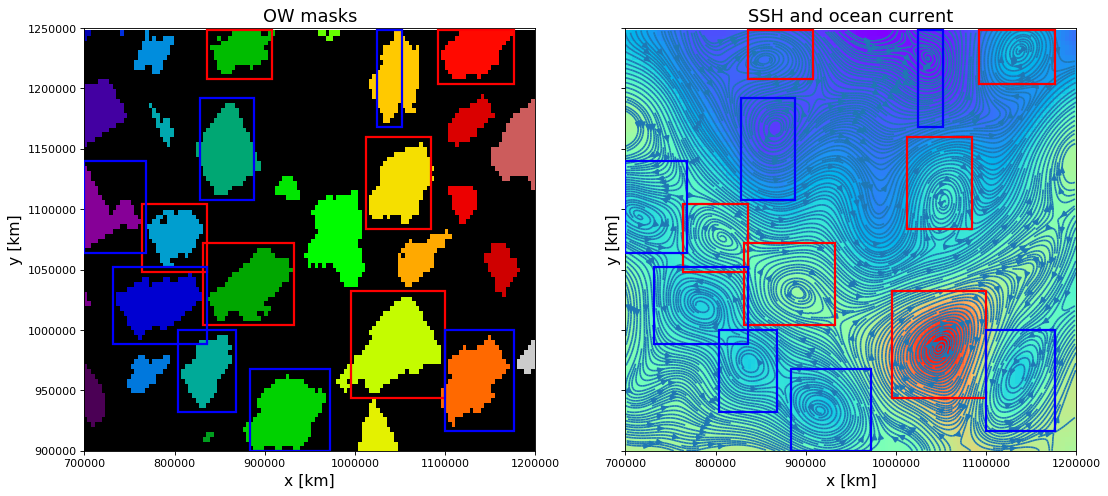

In [31]:
fig, ax = plt.subplots(1,2,figsize=(16,7), sharey=True, sharex=True, dpi=80)

ax[0].pcolormesh(x_sinmod, y_sinmod, OW_mask_labeled.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[0], cyc_boxcoords_obs, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0], acyc_boxcoords_obs, 'b', numbered=False) 
ax[0].set_title('OW masks', size=16)
ax[0].set_ylabel('y [km]', size=14)
ax[0].set_xlabel('x [km]', size=14)

ax[1].pcolormesh(x_sinmod, y_sinmod, ssl_obs_samegrid.T, cmap='rainbow')
ax[1].streamplot(x_sinmod, y_sinmod, uvel_obs_samegrid.T, vvel_obs_samegrid.T, density=6) 
tools.system_tools.plot_eddies(ax[1], cyc_boxcoords_obs, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[1], acyc_boxcoords_obs, 'b', numbered=False) 
ax[1].set_title('SSH and ocean current', size=16)
ax[1].set_ylabel('y [km]', size=14)
ax[1].set_xlabel('x [km]', size=14)

plt.ylim(y_bnds)
plt.xlim(x_bnds)

### Show box surrounding the marked OW clusters before and after

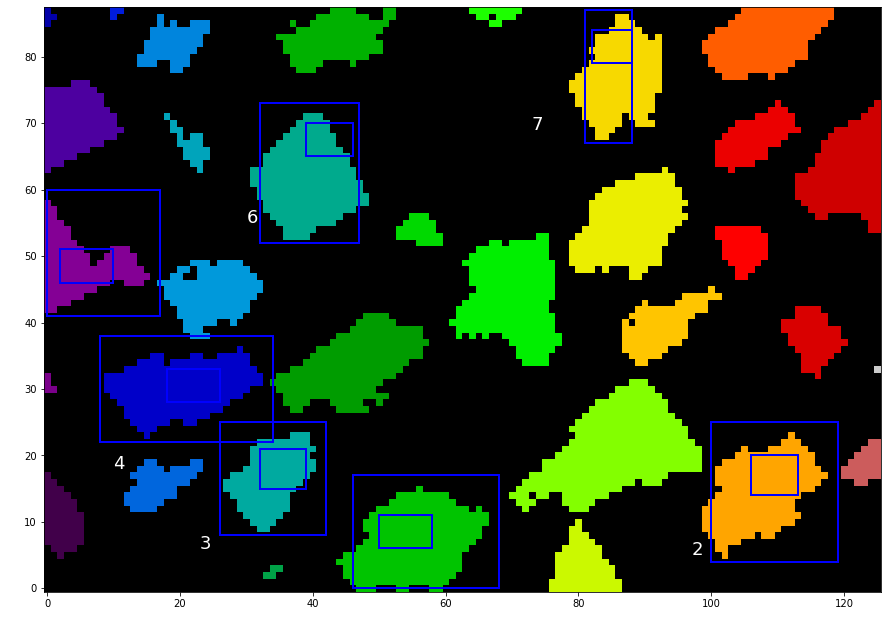

In [32]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(OW_mask_labeled.T, cmap='nipy_spectral', origin='lower')
# Before
#tools.system_tools.plot_eddies(ax, [cyc_obs[0]], 'r', numbered=False) 
tools.system_tools.plot_eddies(ax, acyc_obs, 'b') 
# After
#tools.system_tools.plot_eddies(ax, [cyc_new_obs[0]], 'r', numbered=False) 
tools.system_tools.plot_eddies(ax, acyc_new_obs, 'b', numbered=False) 

#ax.set_xlim([7, 25])
#ax.set_ylim([4, 25])

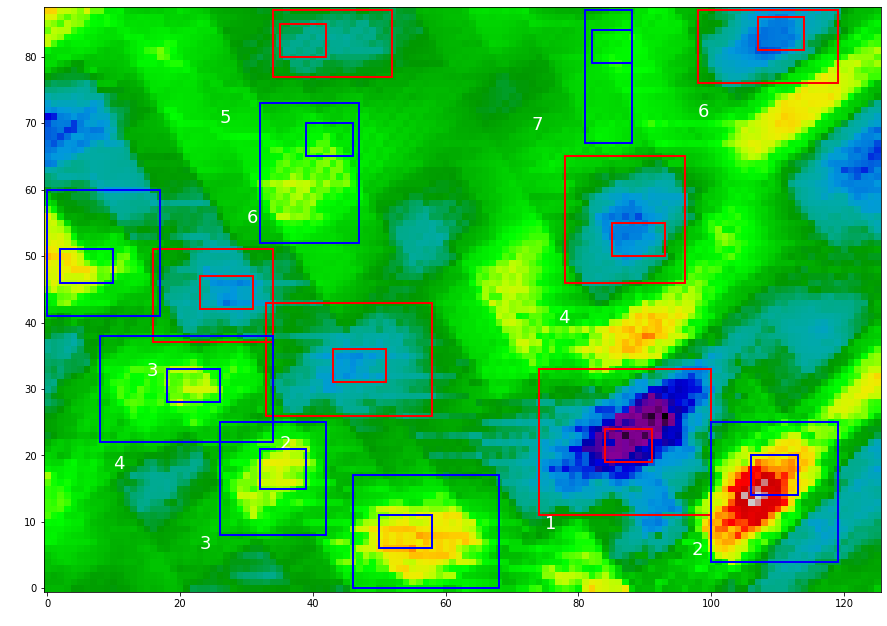

In [33]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(vorticity.T, cmap='nipy_spectral', origin='lower')
# Before
plot_eddies(ax, cyc_obs, 'r') 
plot_eddies(ax, acyc_obs, 'b') 
# After
plot_eddies(ax, cyc_new_obs, 'r', numbered=False) 
plot_eddies(ax, acyc_new_obs, 'b', numbered=False) 

### Show plot of velocity streamplot and sea surface level with new boxes

Text(0.5, 1.0, 'Predictions with sliding window')

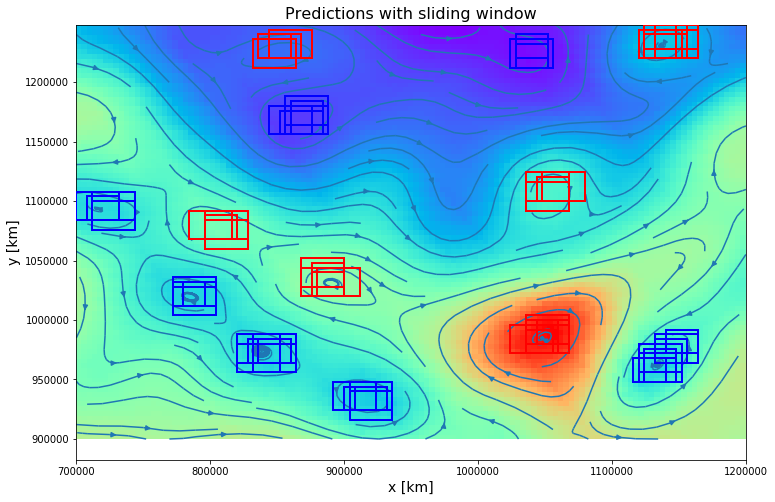

In [34]:
fig, ax = plt.subplots(1,1,figsize=(12,8), sharey=True)#, dpi=100)
ax.pcolormesh(x_sinmod, y_sinmod, ssl_obs_samegrid.T, cmap='rainbow')
ax.streamplot(x_sinmod, y_sinmod, uvel_obs_samegrid.T, vvel_obs_samegrid.T)#, density=8) 
cyc_box = box2coords(x_sinmod, y_sinmod, cyclones_obs)
acyc_box = box2coords(x_sinmod, y_sinmod, anticyclones_obs)
tools.system_tools.plot_eddies(ax, cyc_box, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax, acyc_box, 'b', numbered=False) 
#ax[0].set_ylim([900000, 1200000])
#ax[0].set_xlim([700000, 1200000])
ax.set_ylabel('y [km]', size=14)
ax.set_xlabel('x [km]', size=14)
ax.set_title('Predictions with sliding window', size=16)



In [35]:
# Eddy census dataframe to hold information about each eddy
cyc_census_df_obs = set_eddy_census(cyc_mask_labeled_obs, cyc_ctrIdxs, cyc_new_obs, cyc_minOW, lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, uvel_obs_samegrid, vvel_obs_samegrid, meastype='SINMOD')
acyc_census_df_obs = set_eddy_census(acyc_mask_labeled_obs, acyc_ctrIdxs, acyc_new_obs, acyc_minOW, lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, uvel_obs_samegrid, vvel_obs_samegrid, meastype='SINMOD')

# Process SINMOD data

### Perform pyramid sliding window on grid and return use CNN model to predict rectangles

In [38]:
%%capture
importlib.reload(cnn)
model_fpath = 'C:/Users/47415/Master/TTK-4900-Master/models/cnn_model_975.h5'
cnn_win_sizes = [((int(6), int(5)), 2, 2),((int(8), int(6)), 3, 2)]#,((int(11), int(8)), 3, 2)]
#cnn_win_sizes = [((int(8), int(6)), 2, 2)]
cnn_data = [lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, ssl_sinmod, uvel_sinmod, vvel_sinmod]
# Get the cyclone and anti-cyclone rectangle 
cyclones_sinmod, anticyclones_sinmod, _, _= cnn.cnn_predict_grid(cnn_data, cnn_win_sizes, 0.92, model_fpath, storedir="phys1")

In [39]:
# Group all predicted boxes according to overlap and number of rectangles in a group
cyc_sinmod, _ = cv2.groupRectangles(rectList=cyclones_sinmod, groupThreshold=1, eps=0.15)
acyc_sinmod, _ = cv2.groupRectangles(rectList=anticyclones_sinmod, groupThreshold=1, eps=0.15)
nCyc, nAcyc = len(cyc_sinmod), len(acyc_sinmod)

### Use labeled binary clusters for each cyclone or anti-cyclone based on Okubo Weiss parameter and vorticity to find appropriate box surrounding the eddy

In [40]:
%%capture
# Create mask for OW values above threshold, one that contains cyclones (negative vorticity) 
# and vice versa for anti-cyclones
# Default Okubo Weiss value was -1, want to use -8 to be absolutely sure, we have a more loose threshold to
# indicate cells with vortex characteristics
OW_start = -0.05
OW,vorticity,OW_mask,OW_cyc_mask,OW_acyc_mask = calc_OW(lons_sinmod,lats_sinmod,uvel_sinmod,vvel_sinmod,OW_start)

# We label all unique mask clusters
OW_mask_labeled = measure.label(OW_mask)
cyc_mask_labeled_sinmod = measure.label(OW_cyc_mask)
acyc_mask_labeled_sinmod = measure.label(OW_acyc_mask)

# Make the predicted boxes encompass the full cyclone or anti-cyclone clusters and return info about the eddy
cyc_ctrIdxs, cyc_minOW, cyc_new_sinmod = investigate_cluster(cyc_sinmod, OW, cyc_mask_labeled_sinmod, 'cyclone')
acyc_ctrIdxs, acyc_minOW, acyc_new_sinmod = investigate_cluster(acyc_sinmod, OW, acyc_mask_labeled_sinmod, 'anti-cyclone')

# Eddy boxes given in lat-lon coordiantes
cyc_boxcoords_sinmod = box2coords(x_sinmod, y_sinmod, cyc_new_sinmod)
acyc_boxcoords_sinmod = box2coords(x_sinmod, y_sinmod, acyc_new_sinmod)

### Show box surrounding the marked OW clusters before and after

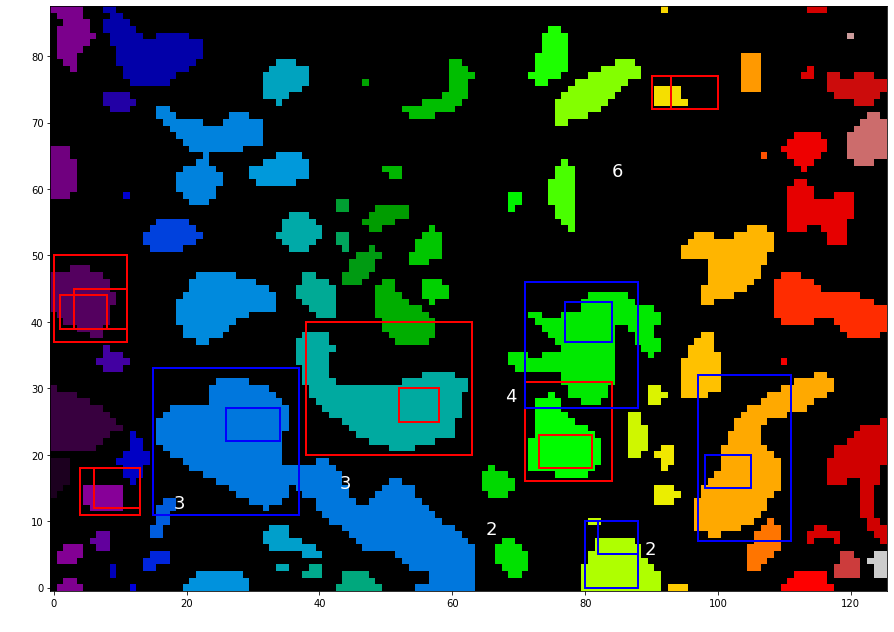

In [41]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.imshow(OW_mask_labeled.T, cmap='nipy_spectral', origin='lower')
# Before
plot_eddies(ax, cyc_sinmod, 'r') 
plot_eddies(ax, acyc_sinmod, 'b') 
# After
plot_eddies(ax, cyc_new_sinmod, 'r', numbered=False) 
plot_eddies(ax, acyc_new_sinmod, 'b', numbered=False) 

(700000, 1200000)

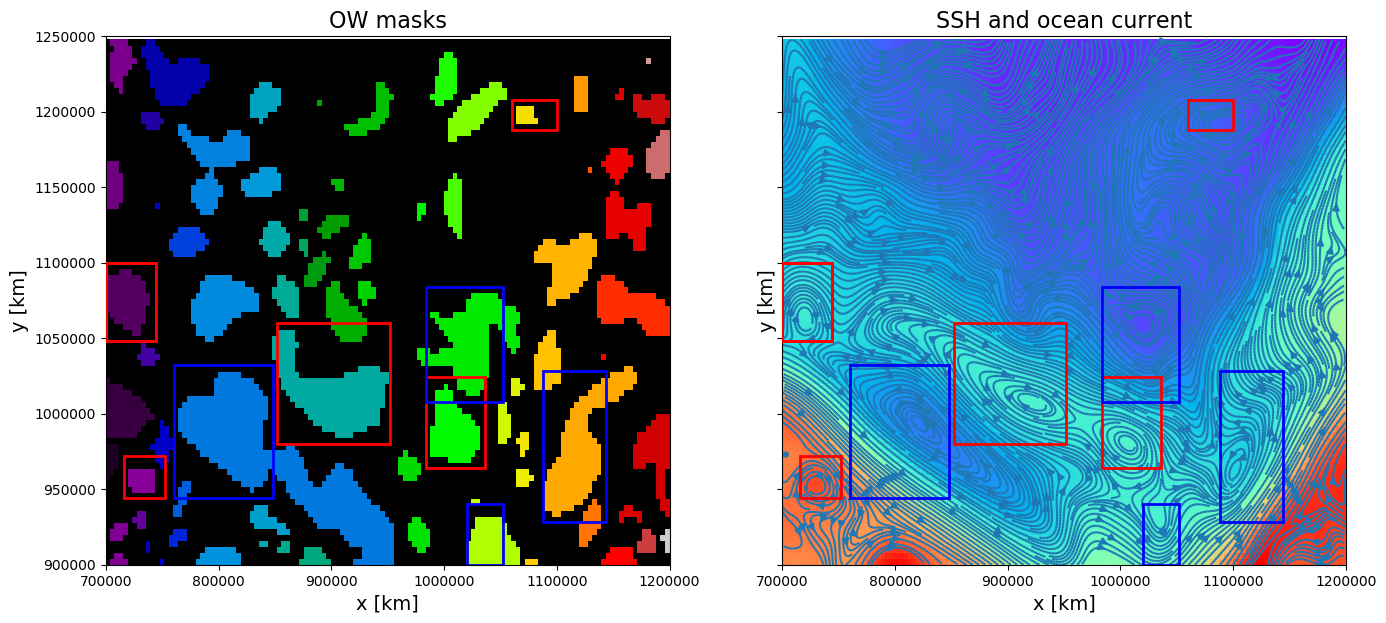

In [42]:
fig, ax = plt.subplots(1,2,figsize=(16,7), sharey=True, sharex=True, dpi=100)

ax[0].pcolormesh(x_sinmod, y_sinmod, OW_mask_labeled.T, cmap='nipy_spectral')
tools.system_tools.plot_eddies(ax[0], cyc_boxcoords_sinmod, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[0], acyc_boxcoords_sinmod, 'b', numbered=False) 
ax[0].set_title('OW masks', size=16)
ax[0].set_ylabel('y [km]', size=14)
ax[0].set_xlabel('x [km]', size=14)

ax[1].pcolormesh(x_sinmod, y_sinmod, ssl_sinmod.T, cmap='rainbow')
ax[1].streamplot(x_sinmod, y_sinmod, uvel_sinmod.T, vvel_sinmod.T, density=6) 
tools.system_tools.plot_eddies(ax[1], cyc_boxcoords_sinmod, 'r', numbered=False) 
tools.system_tools.plot_eddies(ax[1], acyc_boxcoords_sinmod, 'b', numbered=False) 
ax[1].set_title('SSH and ocean current', size=16)
ax[1].set_ylabel('y [km]', size=14)
ax[1].set_xlabel('x [km]', size=14)

plt.ylim(y_bnds)
plt.xlim(x_bnds)

### Show plot of velocity streamplot and sea surface level with new boxes

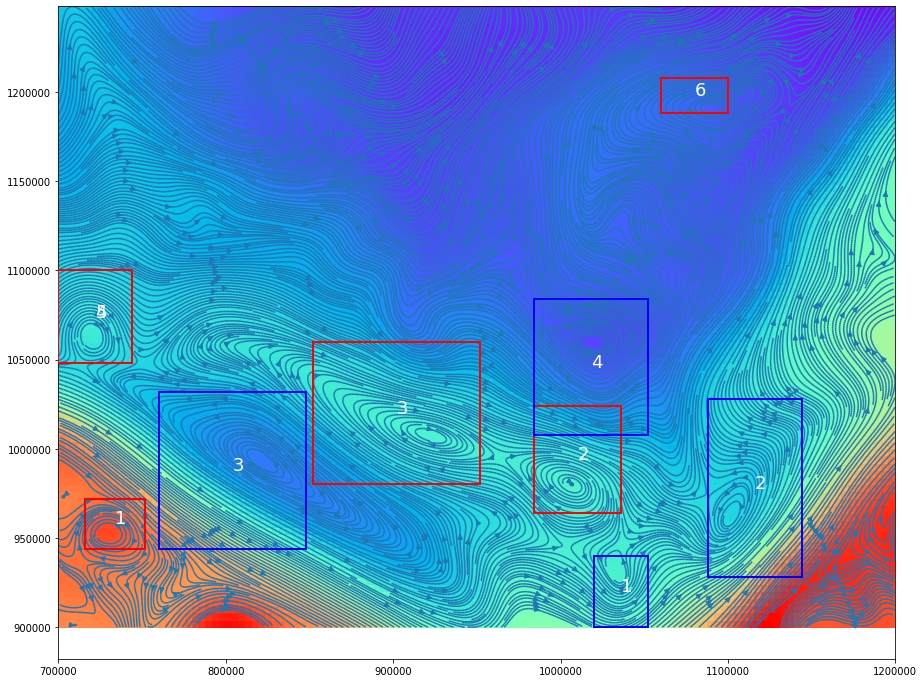

In [45]:
fig, ax = plt.subplots(1,1,figsize=(15,12))#, dpi=500)
ax.pcolormesh(x_sinmod, y_sinmod, ssl_sinmod.T, cmap='rainbow')
#ax.quiver(x_sinmod,y_sinmod,uvel_sinmod.T,vvel_sinmod.T,scale=5)
ax.streamplot(x_sinmod, y_sinmod, uvel_sinmod.T, vvel_sinmod.T, density=10) 
plot_eddies(ax, cyc_boxcoords_sinmod, 'r') 
plot_eddies(ax, acyc_boxcoords_sinmod, 'b') 

In [48]:
cyc_census_df_sinmod = set_eddy_census(cyc_mask_labeled_sinmod, cyc_ctrIdxs, cyc_new_sinmod, cyc_minOW, lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, uvel_sinmod, vvel_sinmod, meastype='SINMOD')
acyc_census_df_sinmod = set_eddy_census(acyc_mask_labeled_sinmod, acyc_ctrIdxs, acyc_new_sinmod, acyc_minOW, lons_sinmod, lats_sinmod, x_sinmod, y_sinmod, uvel_sinmod, vvel_sinmod, meastype='SINMOD')

# Compare the two

### Eddy census

In [49]:
cyc_census_df_phys

minOW    lon[º]     lat[º]  cells  width[km]  height[km]  \
1  -4.704316  5.046268  64.141174   28.0       36.0        28.0   
2  -3.681339  4.773643  65.146957   96.0       64.0        52.0   
3  -4.673560  3.107113  64.481522  297.0       80.0       112.0   
4  -0.471374 -0.392502  62.576454   34.0       48.0        28.0   
5  -0.553592  0.138573  63.241505   71.0       56.0        48.0   
6  -5.096637  3.707821  65.473289   46.0       36.0        44.0   
7  -1.813515  4.120331  65.896286   28.0       20.0        20.0   
8  -8.926504 -2.075871  62.992401   96.0       60.0        52.0   
9  -4.353942  0.764252  65.239899   98.0       52.0        60.0   
10 -3.431027  2.020294  66.224014   88.0       56.0        24.0   
11 -3.373826 -3.549431  63.987595  190.0       84.0        56.0   
12 -1.207014 -1.238178  65.068687   54.0       44.0        48.0   
13 -0.966493 -0.674644  65.743889  112.0       72.0        40.0   
14 -2.476452  0.147804  66.492775   46.0       48.0        28.0   

    ciculation[m/s]  
1          0.048706  
2          0.048810  
3          0.045053  
4          0.049833  
5          0.050119  
6          0.046876  
7          0.047391  
8          0.050537  
9          0.050351  
10         0.050639  
11         0.049076  
12         0.049083  
13         0.049106  
14         0.049441

In [50]:
acyc_census_df_phys

minOW    lon[º]     lat[º]  cells  width[km]  height[km]  \
1  -2.008000  5.274590  64.756844   73.0       52.0        48.0   
2  -2.167394  1.577393  63.301529   96.0       56.0        52.0   
3  -0.691041  0.169586  62.715904   44.0       28.0        60.0   
4  -4.101993  4.754131  65.566521   48.0       36.0        20.0   
5  -6.963839 -0.842251  62.234924   70.0       44.0        52.0   
6  -1.967044 -0.920025  62.809120   73.0       44.0        48.0   
7  -6.885179  1.264874  64.488388   92.0       64.0        56.0   
8  -1.194144  0.302509  64.797493   58.0       52.0        40.0   
9  -1.959834 -2.052395  63.449547   34.0       32.0        36.0   
10 -1.987272  1.086578  65.987663  112.0       72.0        60.0   
11 -2.904320 -0.375088  65.452148   50.0       52.0        36.0   

    ciculation[m/s]  
1          0.049921  
2          0.050704  
3          0.045923  
4          0.050376  
5          0.048814  
6          0.047767  
7          0.049263  
8          0.049509  
9          0.046375  
10         0.047337  
11         0.051351

In [51]:
cyc_census_df_sinmod

minOW    lon[º]     lat[º]  cells  width[km]  height[km]  \
1 -26.970464  0.368011  61.840858   23.0       36.0        28.0   
2  -1.322729  2.585052  64.414841  128.0       52.0        60.0   
3  -3.235486  0.658234  63.743378  325.0      100.0        80.0   
4  -1.798640 -1.566189  62.308739   79.0       44.0        52.0   
5  -1.798640 -1.566189  62.308739   79.0       44.0        52.0   
6  -0.069324 -0.046772  65.671310   13.0       40.0        20.0   

   ciculation[m/s]  
1         0.012334  
2         0.055422  
3         0.159638  
4         0.023035  
5         0.023035  
6         0.014978

In [52]:
acyc_census_df_sinmod

minOW    lon[º]     lat[º]  cells  width[km]  height[km]  \
1 -2.890816  4.761696  63.914246   65.0       32.0        40.0   
2 -6.805115  4.844254  64.573914  171.0       56.0       100.0   
3 -1.470046  0.209263  62.403381  269.0       88.0        88.0   
4 -1.572949  2.515087  64.435646  166.0       68.0        76.0   

   ciculation[m/s]  
1         0.014059  
2         0.088188  
3         0.103238  
4         0.064799

### Compare data; temperature, sea surface level, streamplot

Text(0.5, 1.0, 'Salinity SINMOD')

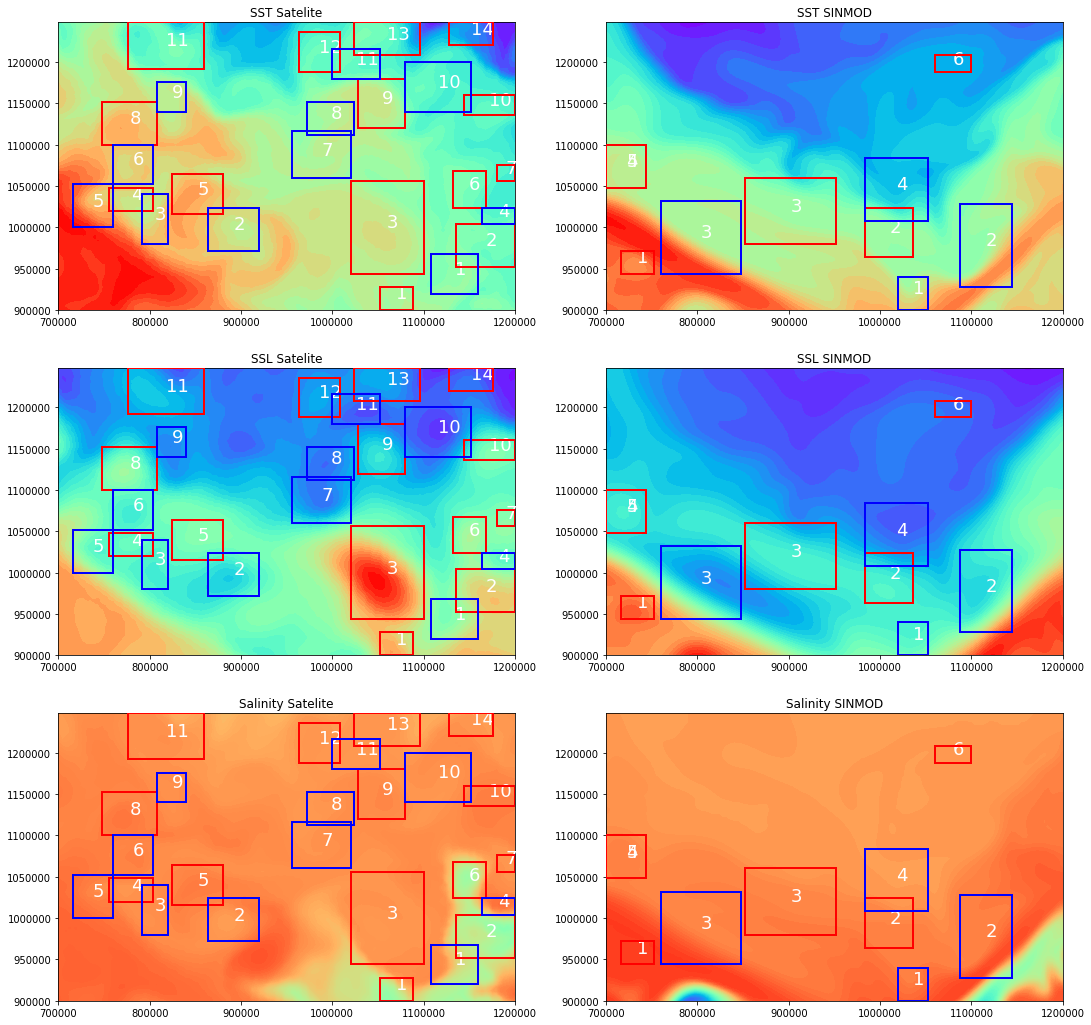

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))

def plot_eddies_wrapper(ax, cyc, acyc):
    plot_eddies(ax, cyc, 'r') 
    plot_eddies(ax, acyc, 'b') 

axes[0,0].contourf(x_sinmod, y_sinmod, sst_phys_samegrid.T, levels=40, cmap='rainbow')#, vmin=6.5, vmax=10.5)
plot_eddies_wrapper(axes[0,0], cyc_boxcoords_phys, acyc_boxcoords_phys)
axes[0,0].set_title('SST Satelite')

axes[0,1].contourf(x_sinmod, y_sinmod, sst_sinmod.T, levels=40, cmap='rainbow')
plot_eddies_wrapper(axes[0,1], cyc_boxcoords_sinmod, acyc_boxcoords_sinmod)
axes[0,1].set_title('SST SINMOD')

axes[1,0].contourf(x_sinmod, y_sinmod, ssl_phys_samegrid.T, levels=40, cmap='rainbow')
plot_eddies_wrapper(axes[1,0], cyc_boxcoords_phys, acyc_boxcoords_phys)
axes[1,0].set_title('SSL Satelite')

axes[1,1].contourf(x_sinmod, y_sinmod, ssl_sinmod.T, levels=40, cmap='rainbow')
plot_eddies_wrapper(axes[1,1], cyc_boxcoords_sinmod, acyc_boxcoords_sinmod)
axes[1,1].set_title('SSL SINMOD')

axes[2,0].contourf(x_sinmod, y_sinmod, sal_phys_samegrid.T, levels=80, cmap='rainbow', vmin=33, vmax=35.6)
plot_eddies_wrapper(axes[2,0], cyc_boxcoords_phys, acyc_boxcoords_phys)
axes[2,0].set_title('Salinity Satelite')

axes[2,1].contourf(x_sinmod, y_sinmod, sal_sinmod.T, levels=100, cmap='rainbow', vmin=33, vmax=35.6)
plot_eddies_wrapper(axes[2,1], cyc_boxcoords_sinmod, acyc_boxcoords_sinmod)
axes[2,1].set_title('Salinity SINMOD')